In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from IPython.display import display


In [2]:
%load_ext autoreload
%autoreload 2
    
from simulation_tools import Population
from simulation_tools import Transformation
from simulation_tools import Metric
from simulation_tools import Experiment


In [38]:
def distributionplot(df_in, title, col1, col2, file_name):
    '''
    Create Distribution plots for the two delta vectors
    '''
    # Copy DF and flatten indices
    full_df_reset = df_in.copy(deep=True)
    full_df_reset.reset_index(inplace=True)
    # Get distributions of actual and observed change
    actual_dist = full_df_reset['actual_change']
    obs_dist = full_df_reset['observed_change']
    plt.figure(figsize=(10,6))
    sns.distplot(actual_dist,hist=False,label='actual', color=col1)
    sns.distplot(obs_dist,hist=False,label='observed', color=col2)
    plt.xlabel('Change in distance travelled')
    plt.title(f'Distribution of changes in distance travelled - {title}')
    plt.legend()
    
    plt.savefig("results/"+file_name+".png", bbox_inches='tight')
    plt.show()
    
    import scipy.stats as stats
    print(stats.ttest_rel(actual_dist,obs_dist))
    print(stats.ks_2samp(actual_dist,obs_dist))
    


def rankingDFs(df_in, ntrials):
    '''
    Creates 3 dataframes of actual, observed and difference 
    representing rankings in change in distance traveled before/after across multiple trials
    '''
    full_df_reset = df_in.copy(deep=True)
    full_df_reset.reset_index(inplace=True)
    # Set up 3 dataframes
    df_rankchanges = pd.DataFrame(index=np.unique(full_df_reset.location_name))
    df_rankactual = pd.DataFrame(index=np.unique(full_df_reset.location_name))
    df_rankobs = pd.DataFrame(index=np.unique(full_df_reset.location_name))
    # Loop through each trial and compute ranks for observed,actual and compute delta-rank
    # Put them in their own DFs
    for trialnum in range(1,ntrials+1):
        this_trial = full_df_reset.copy()
        # Extract just the current trial in question
        thistrialname = 'trial'+str(trialnum)
        this_trial = this_trial[this_trial['population_name']==thistrialname]
        this_trial.set_index('location_name',inplace=True)
        # Compute ranks for this trial
        actual_rank_i=(-this_trial['actual_change']).rank()
        obs_rank_i=(-this_trial['observed_change']).rank()
        # Add actual and observed ranks for current trial to DFs
        df_rankactual[thistrialname]=actual_rank_i
        df_rankobs[thistrialname]=obs_rank_i
        # compute differnce in ranks for current trial and add to DF
        thisrankchange = 'rank_change_'+str(trialnum)
        df_rankchanges[thisrankchange]=obs_rank_i-actual_rank_i
    return(df_rankactual,df_rankobs,df_rankchanges)


def topFivePlot(df_rankactual,df_rankobs,experiment,col1,col2,file_name,ntrials):
    '''
    Create Actual/Observed grouped bar plot of percent of trials county is in top5 most reduced travel
    '''
    # Create new top5 DF
    df_top5 = pd.DataFrame(index=np.unique(df_rankactual.index))
    # Compute percentage of actual and observed ranks that are within top5
    df_top5['Actual'] = df_rankactual.copy().apply(lambda row: len(np.where(row<=5)[0])/ntrials ,axis=1)
    df_top5['Observed'] = df_rankobs.copy().apply(lambda row: len(np.where(row<=5)[0])/ntrials ,axis=1)
    df_top5.reset_index(inplace=True)
    df_top5.rename(columns={'index':'Location'},inplace=True)
    # Reformat DF for catplot
    df_top5_melt = pd.melt(df_top5,id_vars='Location',var_name='Condition',value_name='Proportion of Trials in Top 5 Worst Distancing',value_vars=['Actual','Observed'])
    df_top5_melt.sort_values('Location',inplace=True)
    # Plot top5
    plt.figure(figsize=(15,6))
    g=sns.catplot(x='Location', y="Proportion of Trials in Top 5 Worst Distancing", height=6, aspect=2,hue="Condition", palette=[col1,col2], data=df_top5_melt, kind="bar")
    g.set_xticklabels(rotation=90)
    plt.title(f'Proportion of trials the county is in Top5 least reduced travel for {experiment} test')
    plt.savefig("results/"+file_name+".png", bbox_inches='tight')
    plt.show()
    
    
def rankchangesPlot(df_rankchanges,experiment,col1,file_name):
    '''
    Create barplot of how mean ranking of most-least decrease in travel varies across counties
    with error bars representing between trial variety
    '''
    df_rankchanges_all = df_rankchanges.copy(deep=True)
    df_rankchanges_all['mean']=df_rankchanges.mean(axis=1)
    df_rankchanges_all['minus']=df_rankchanges.mean(axis=1)-df_rankchanges.min(axis=1)
    df_rankchanges_all['plus']=df_rankchanges.max(axis=1)-df_rankchanges.mean(axis=1)
    plt.figure(figsize=(14,6))
    plt.bar(df_rankchanges_all.index,df_rankchanges_all['mean'],color=col1,yerr=(df_rankchanges_all['plus'],df_rankchanges_all['minus']),capsize=5)
    plt.xticks(rotation=90)
    plt.title(f'Change between actual/observed ranking of travel decrease across counties for {experiment} test')
    plt.ylabel('Ranks changed')
    plt.xlabel('County ID')
    plt.savefig("results/"+file_name+".png", bbox_inches='tight')
    plt.show()

In [4]:
# Load data:
SYNTHETIC_DATA = './synthetic_data/'

dummy = False

if dummy:

    location_attributes = pd.read_csv(SYNTHETIC_DATA+'location_attributes_dummy.csv')
    location_profiles = pd.read_csv(SYNTHETIC_DATA+'location_profiles_dummy.csv')

else:
    
    location_attributes = pd.read_csv(SYNTHETIC_DATA+'location_attributes_census.csv')
    location_attributes['location_name'] = location_attributes['location_id']

    location_profiles = pd.read_csv(SYNTHETIC_DATA+'location_profiles_census.csv')
    location_profiles['location_name'] = location_profiles['location_id']
    
    # Limit to one state and divide population by a constant to get reasonable sample size.
    state = 'New York'
    constant = 1000
    location_attributes = location_attributes[location_attributes['location_state']==state]
    location_profiles = location_profiles[location_profiles['location_state']==state]
    location_attributes['population'] = (location_attributes['population']/constant).astype(int)
    
    # Rescale standard deviations:
    location_profiles['worktravel_std'] = np.round(location_profiles['worktravel_std']/20,1)
    location_profiles['socialtravel_std'] = np.round(location_profiles['socialtravel_std']/20,1)
    location_profiles['grocerytravel_std'] = np.round(location_profiles['grocerytravel_std']/20,1)
    
print("Loaded data for {} locations ({} people).".format(
    len(location_attributes),location_attributes['population'].sum()
))

#display(location_attributes.head())
#display(location_profiles.head())


Loaded data for 39 locations (18528 people).


In [5]:
# RUN EXPERIMENTS
num_t = 50

#PARTIAL COMPLIANCE 40% MEAN compliance
experiment_partial_40_mean = Experiment(
    location_attributes, location_profiles, behavior='partial_compliance',
    metric_method='average_person', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='partial_40_mean', random_state=221,
)

#PARTIAL COMPLIANCE 40% MEDIAN compliance
experiment_partial_40_median = Experiment(
    location_attributes, location_profiles, behavior='partial_compliance',
    metric_method='median_person', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='partial_40_median', random_state=221,
)

#TOTAL COMPLIANCE
experiment_totalcomp = Experiment(
    location_attributes, location_profiles, behavior='total_compliance',
    metric_method='average_person', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='totalcomp', random_state=221,
)

#WORK EXP
experiment_work = Experiment(
    location_attributes, location_profiles, behavior='partial_compliance',
    metric_method='skews_work', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='work_skew', random_state=221,
)

#GROCERY EXP
experiment_grocery = Experiment(
    location_attributes, location_profiles, behavior='partial_compliance',
    metric_method='skews_grocery', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='grocery_skew', random_state=221,
)

#BACKLASH EXP
experiment_backlash = Experiment(
    location_attributes, location_profiles, behavior='partial_compliance',
    metric_method='backlash', summary_method='worst5_status',
    trials=num_t, show_progress=True, experiment_name='backlash', random_state=221,
)

In [7]:
# CALCULATE STATISTICS

# Partial Mean
partialmean_full_results = experiment_partial_40_mean.get_results(style='df')
partialmean_means = experiment_partial_40_mean.get_results(style='mean')
partialmean_trial1 = partialmean_full_results.loc[('partial_40_mean', 'trial1'),]


# Partial Median
partialmed_full_results = experiment_partial_40_median.get_results(style='df')
partialmed_means = experiment_partial_40_median.get_results(style='mean')
partialmed_trial1 = partialmed_full_results.loc[('partial_40_median', 'trial1'),]


# Full total compliance
totalcomp_full_results = experiment_totalcomp.get_results(style='df')
totalcomp_means = experiment_totalcomp.get_results(style='mean')
totalcomp_trial1 = totalcomp_full_results.loc[('totalcomp', 'trial1'),]


# Work total compliance
work_full_results = experiment_work.get_results(style='df')
work_means = experiment_work.get_results(style='mean')
work_trial1 = work_full_results.loc[('work_skew', 'trial1'),]


# Grocery total compliance
grocery_full_results = experiment_grocery.get_results(style='df')
grocery_means = experiment_grocery.get_results(style='mean')
grocery_trial1 = grocery_full_results.loc[('grocery_skew', 'trial1'),]


# Backlash total compliance
backlash_full_results = experiment_backlash.get_results(style='df')
backlash_means = experiment_backlash.get_results(style='mean')
backlash_trial1 = backlash_full_results.loc[('backlash', 'trial1'),]

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


## Partial Compliance 40% Results

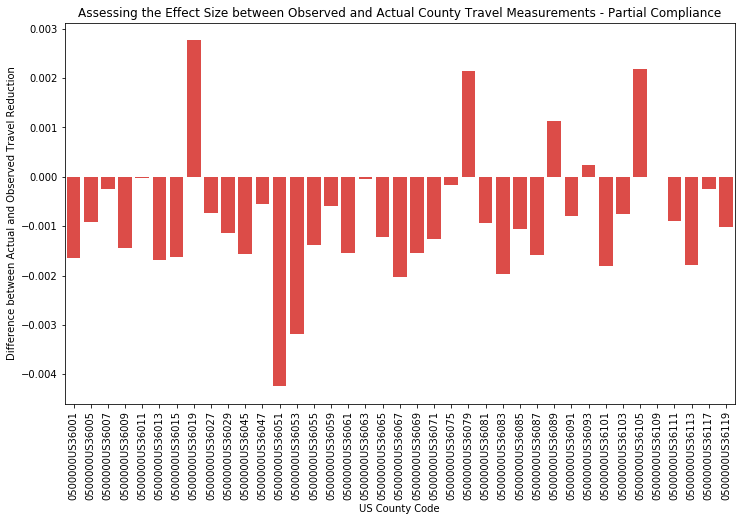

In [8]:
# Mean difference between observed and actual
partialmean_mean_ddelta = partialmean_means['actual_change'] - partialmean_means['observed_change']
partialmean_mean_ddelta = pd.DataFrame(partialmean_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=partialmean_mean_ddelta, x='location_name', y=0, color="#f43530")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Partial Compliance")
plt.xticks(rotation=90)

plt.savefig("results/exp02_biases_partial.png", bbox_inches='tight')

plt.show() 

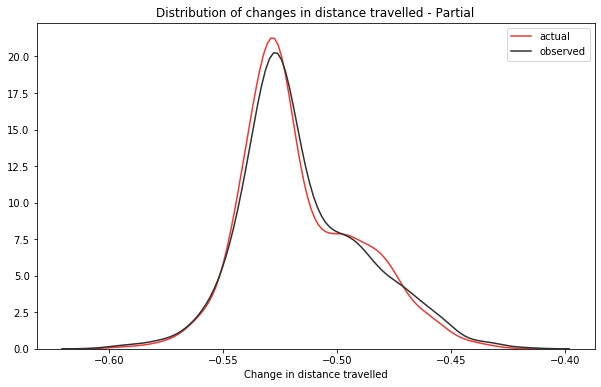

Ttest_relResult(statistic=-4.149826613216674, pvalue=3.4704442883825356e-05)
Ks_2sampResult(statistic=0.036923076923076927, pvalue=0.1400748709350448)


<Figure size 1080x432 with 0 Axes>

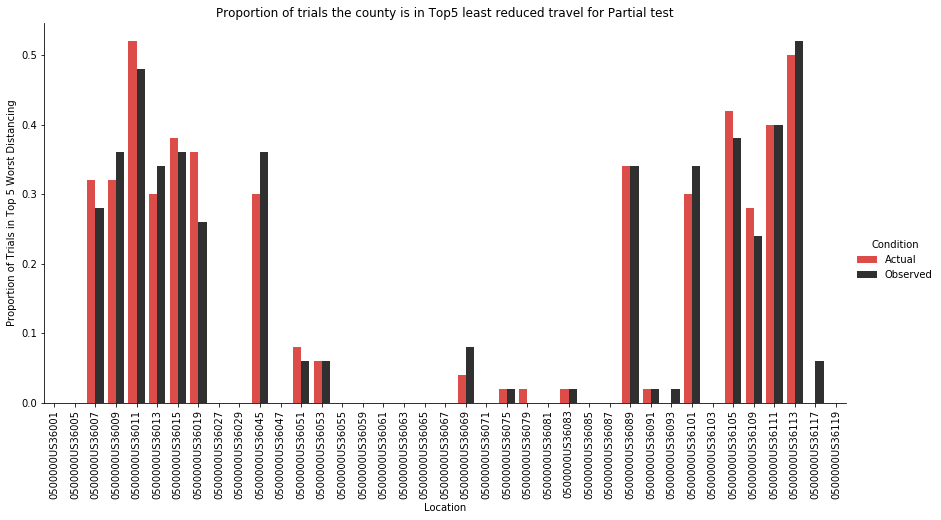

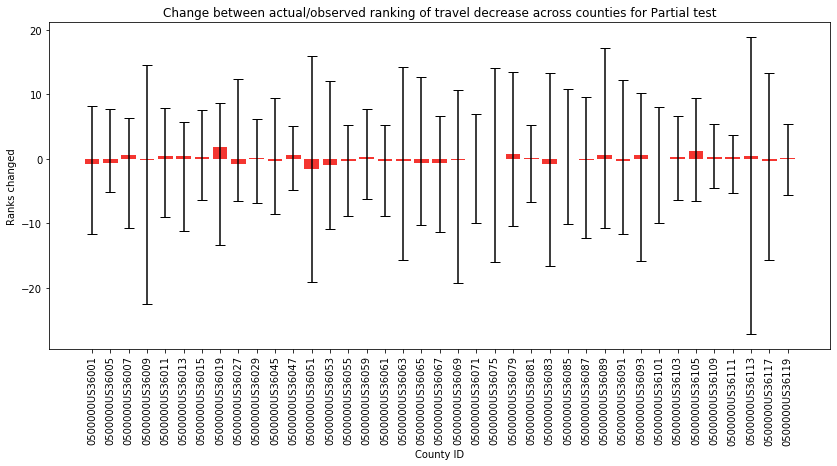

In [39]:
distributionplot(partialmean_full_results, 'Partial', "#f43530", "#303030", "exp02_dist_stat_partial")

part_act, part_obs, part_change = rankingDFs(partialmean_full_results, num_t)
topFivePlot(part_act, part_obs, 'Partial', "#f43530", "#303030", "exp02_top5_partial", num_t)

rankchangesPlot(part_change, 'Partial', "#f43530",  "exp02_rankchange_partial")

## Partial Compliance 40% Median

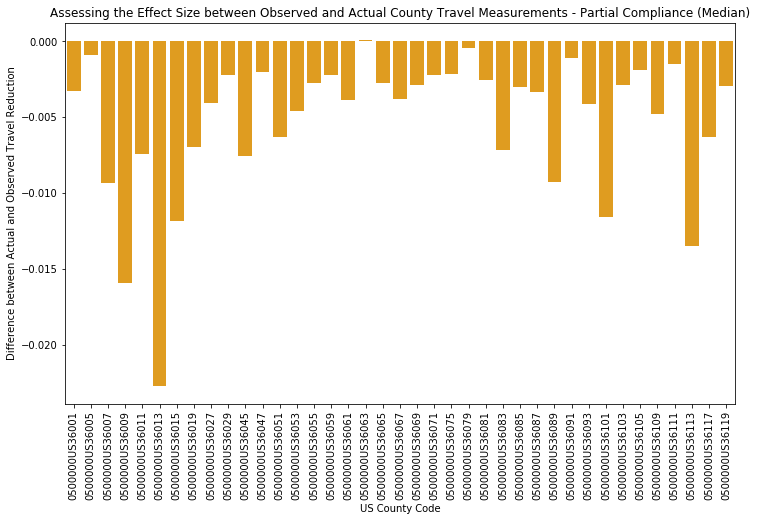

In [30]:
# Mean difference between observed and actual
partialmed_mean_ddelta = partialmed_means['actual_change'] - partialmed_means['observed_change']
partialmed_mean_ddelta = pd.DataFrame(partialmed_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=partialmed_mean_ddelta, x='location_name', y=0, color="#ffa500")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Partial Compliance (Median)")
plt.xticks(rotation=90)

plt.savefig("results/exp03_biases_partial.png", bbox_inches='tight')

plt.show() 

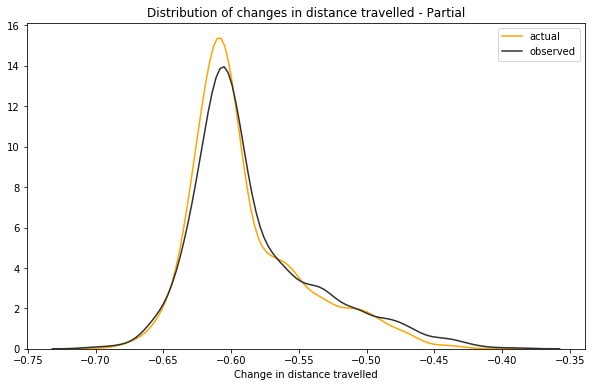

Ttest_relResult(statistic=-11.03107108436001, pvalue=1.727931611452148e-27)
Ks_2sampResult(statistic=0.06820512820512821, pvalue=0.0002287570192052538)


<Figure size 1080x432 with 0 Axes>

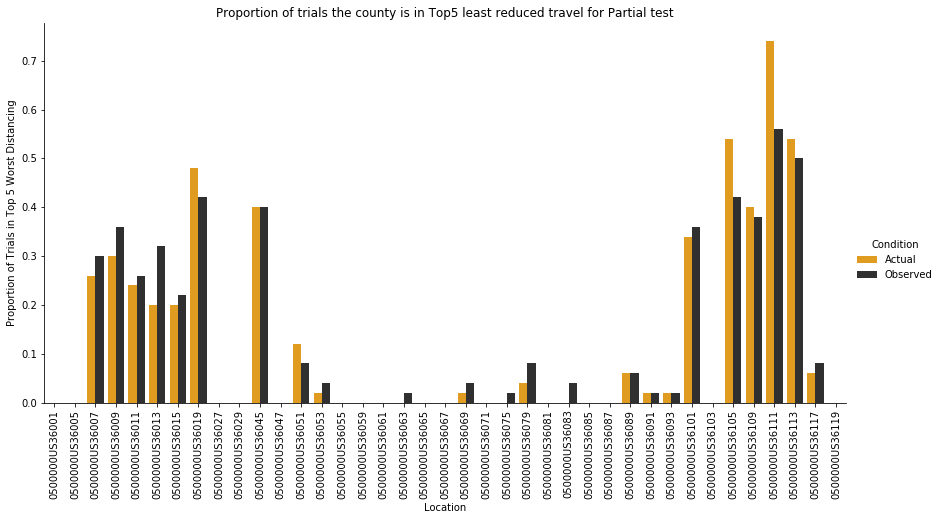

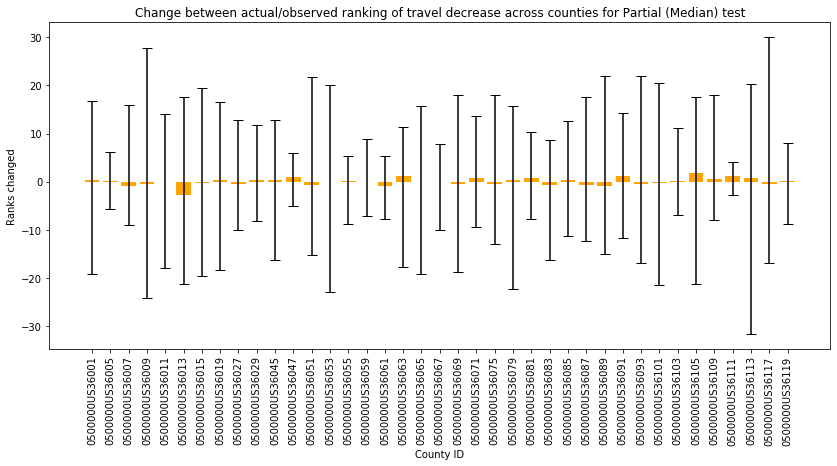

In [40]:
distributionplot(partialmed_full_results, 'Partial', "#ffa500", "#303030", "exp03_dist_stat_partial")

partmed_act, partmed_obs, partmed_change = rankingDFs(partialmed_full_results, num_t)
topFivePlot(partmed_act, partmed_obs, 'Partial', "#ffa500", "#303030", "exp03_top5_partial", num_t)

rankchangesPlot(partmed_change, 'Partial (Median)', "#ffa500",  "exp03_rankchange_partial")

## Total Compliance

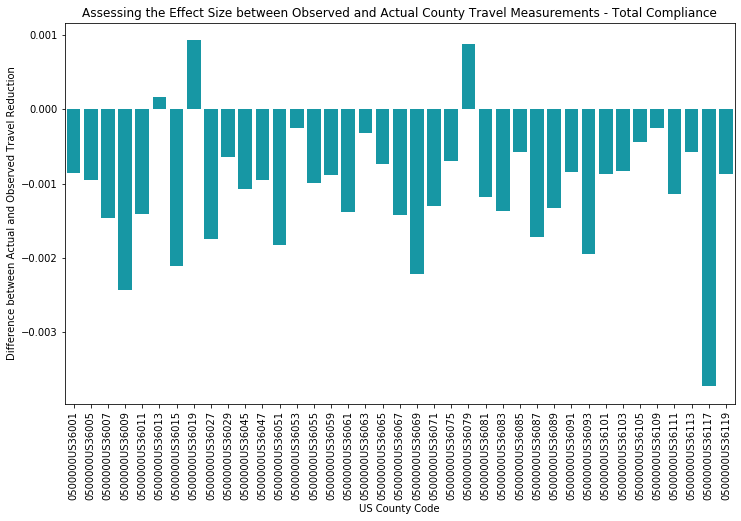

In [33]:
# Mean difference between observed and actual
total_mean_ddelta = totalcomp_means['actual_change'] - totalcomp_means['observed_change']
total_mean_ddelta = pd.DataFrame(total_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=total_mean_ddelta, x='location_name', y=0, color="#00aabb")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Total Compliance")
plt.xticks(rotation=90)

plt.savefig("results/exp01_biases_total.png", bbox_inches='tight')

plt.show() 

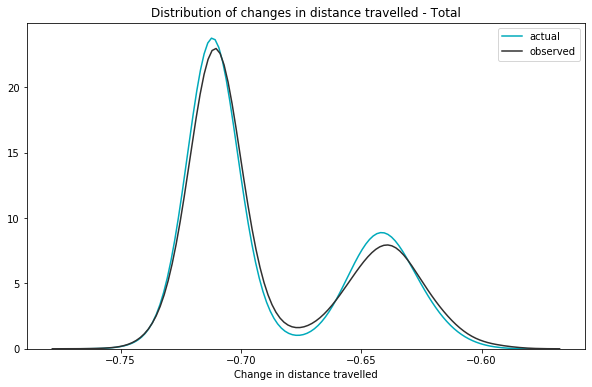

Ttest_relResult(statistic=-8.510893955791737, pvalue=3.389625225563992e-17)
Ks_2sampResult(statistic=0.054871794871794874, pvalue=0.005630385890090894)


<Figure size 1080x432 with 0 Axes>

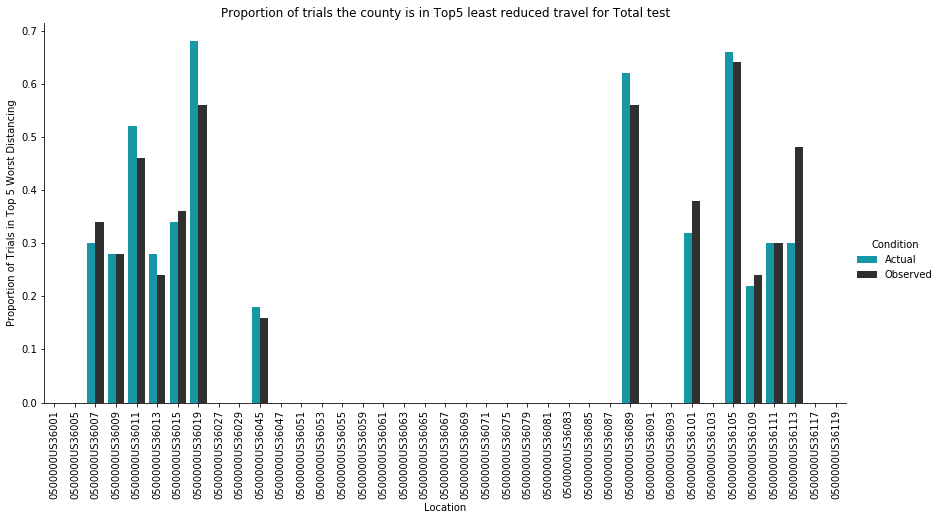

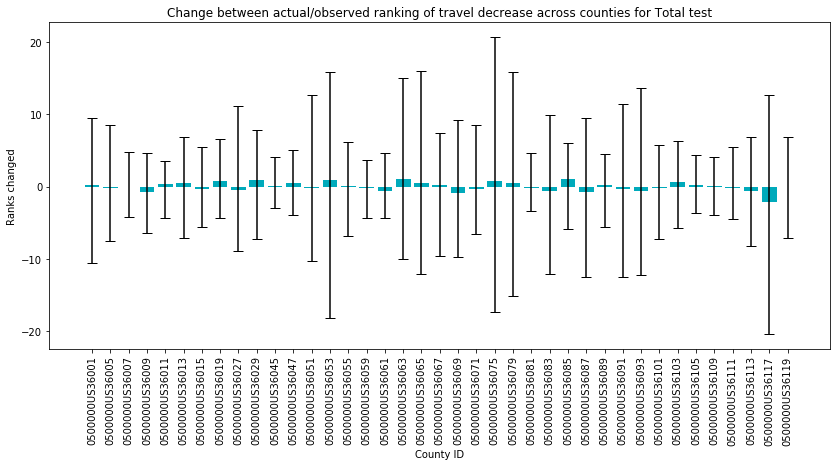

In [41]:
distributionplot(totalcomp_full_results, 'Total', "#00aabb", "#303030", "exp01_dist_stat_total")

tot_act, tot_obs, tot_change = rankingDFs(totalcomp_full_results, num_t)
topFivePlot(tot_act, tot_obs, 'Total', "#00aabb", "#303030", "exp01_top5_total", num_t)

rankchangesPlot(tot_change, 'Total', "#00aabb",  "exp01_rankchange_total")

## Work

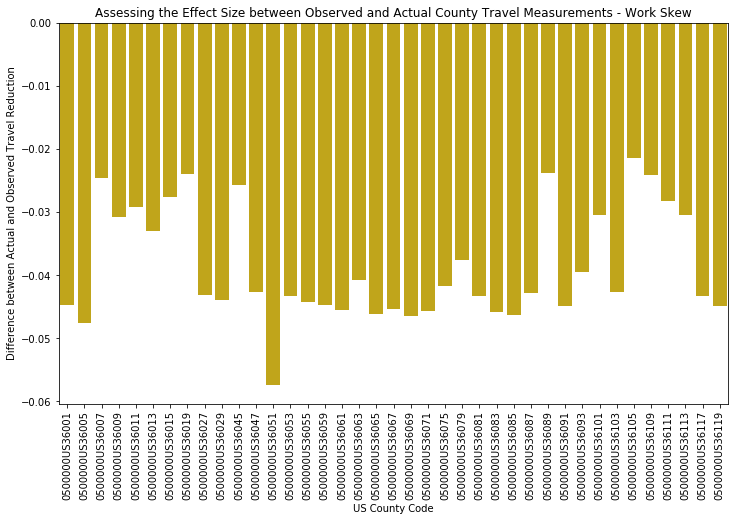

In [36]:
# Mean difference between observed and actual
work_mean_ddelta = work_means['actual_change'] - work_means['observed_change']
work_mean_ddelta = pd.DataFrame(work_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=work_mean_ddelta, x='location_name', y=0, color="#dbb700")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Work Skew")
plt.xticks(rotation=90)

plt.savefig("results/exp04_biases_work.png", bbox_inches='tight')

plt.show() 

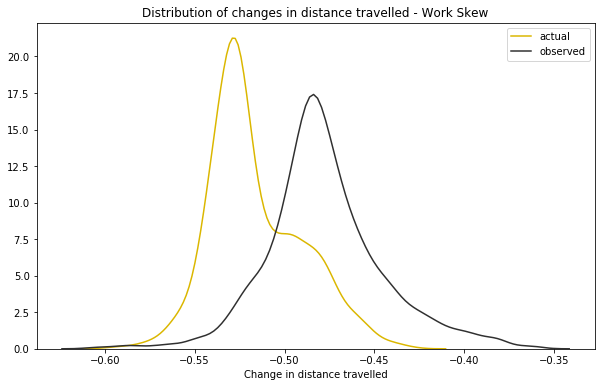

Ttest_relResult(statistic=-82.17277074106822, pvalue=0.0)
Ks_2sampResult(statistic=0.5456410256410257, pvalue=8.886233075128376e-267)


<Figure size 1080x432 with 0 Axes>

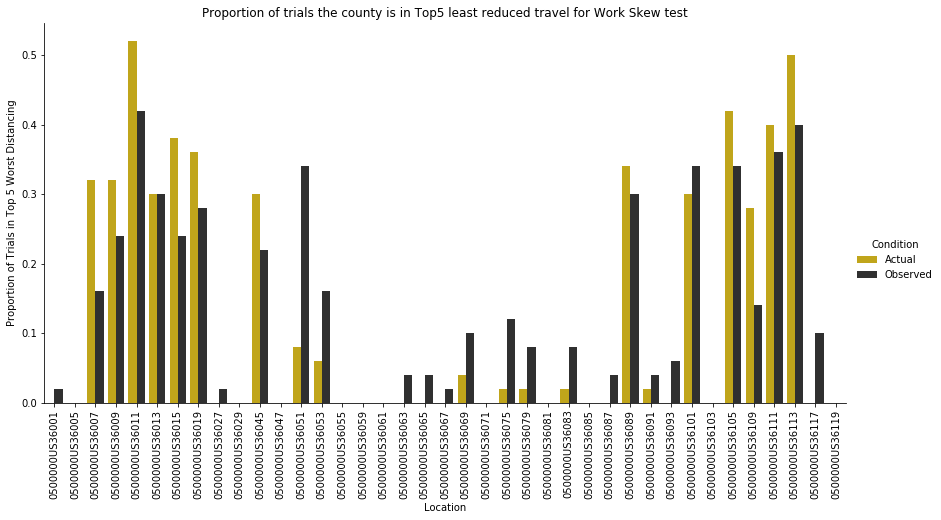

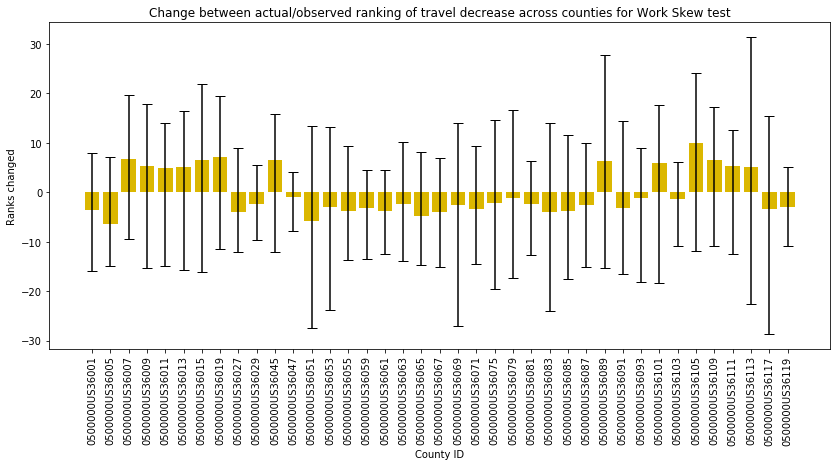

In [42]:
distributionplot(work_full_results, 'Work Skew', "#dbb700", "#303030", "exp04_dist_stat_work")

work_act, work_obs, work_change = rankingDFs(work_full_results, num_t)
topFivePlot(work_act, work_obs, 'Work Skew', "#dbb700", "#303030", "exp04_top5_work", num_t)

rankchangesPlot(work_change, 'Work Skew', "#dbb700",  "exp04_rankchange_work")

## Grocery Results

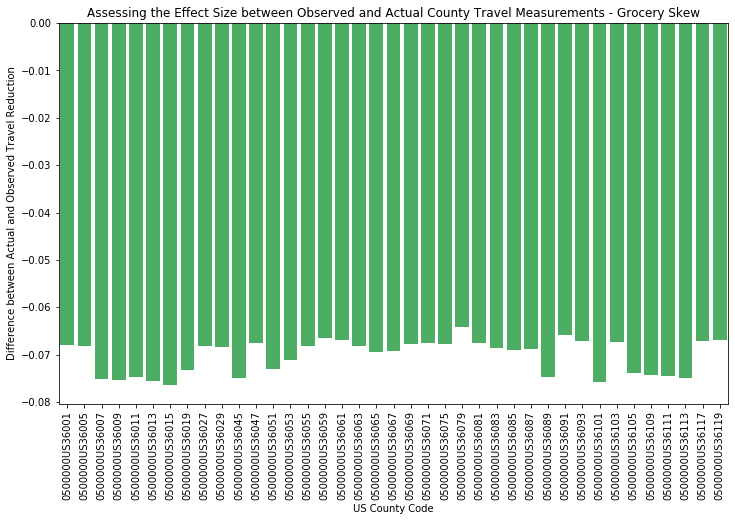

In [44]:
# Mean difference between observed and actual
grocery_mean_ddelta = grocery_means['actual_change'] - grocery_means['observed_change']
grocery_mean_ddelta = pd.DataFrame(grocery_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=grocery_mean_ddelta, x='location_name', y=0, color="#3dbd5d")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Grocery Skew")
plt.xticks(rotation=90)

plt.savefig("results/exp05_biases_grocery.png", bbox_inches='tight')

plt.show() 

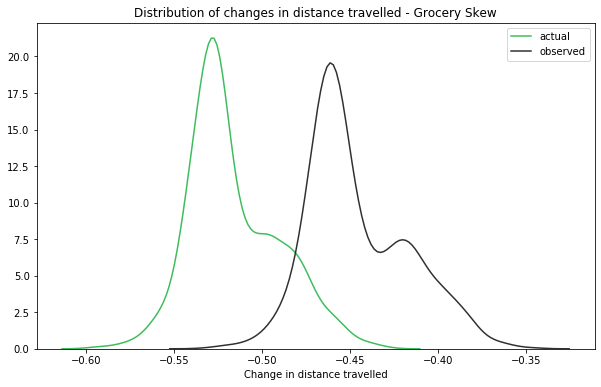

Ttest_relResult(statistic=-341.204180794171, pvalue=0.0)
Ks_2sampResult(statistic=0.8271794871794872, pvalue=0.0)


<Figure size 1080x432 with 0 Axes>

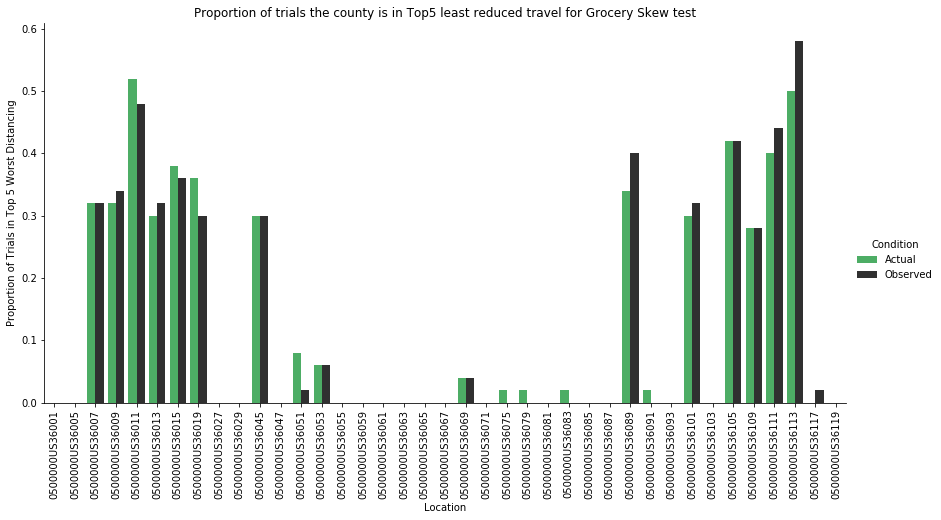

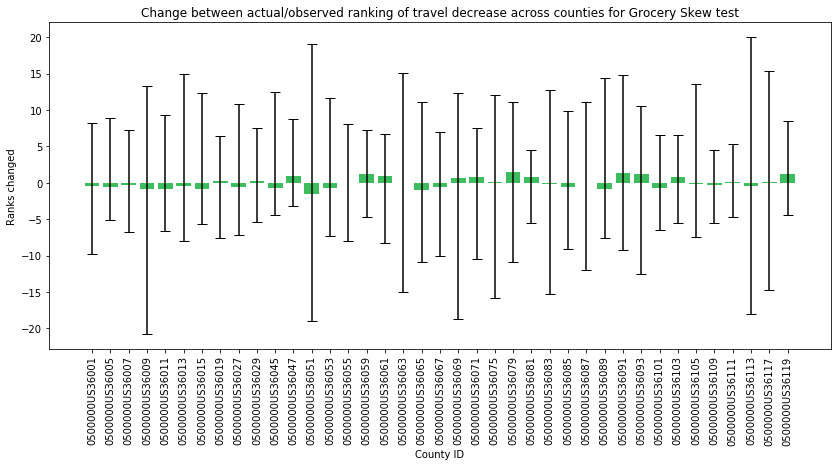

In [43]:
distributionplot(grocery_full_results, 'Grocery Skew', "#3dbd5d", "#303030", "exp05_dist_stat_grocery")

gro_act, gro_obs, gro_change = rankingDFs(grocery_full_results, num_t)
topFivePlot(gro_act, gro_obs, 'Grocery Skew', "#3dbd5d", "#303030", "exp05_top5_grocery", num_t)

rankchangesPlot(gro_change, 'Grocery Skew', "#3dbd5d",  "exp05_rankchange_grocery")

## Backlash Results

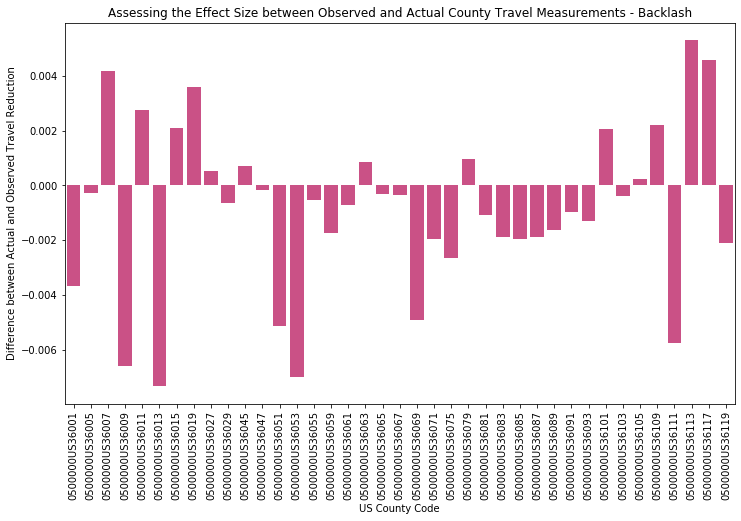

In [45]:
# Mean difference between observed and actual
backlash_mean_ddelta = backlash_means['actual_change'] - backlash_means['observed_change']
backlash_mean_ddelta = pd.DataFrame(backlash_mean_ddelta).reset_index()

plt.figure(figsize=(12,7))

sns.barplot(data=backlash_mean_ddelta, x='location_name', y=0, color="#de3d83")

plt.ylabel("Difference between Actual and Observed Travel Reduction")
plt.xlabel("US County Code")
plt.title("Assessing the Effect Size between Observed and Actual County Travel Measurements - Backlash")
plt.xticks(rotation=90)

plt.savefig("results/exp06_biases_backlash.png", bbox_inches='tight')

plt.show() 

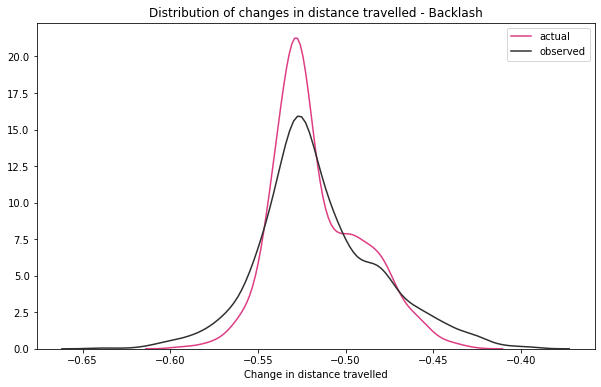

Ttest_relResult(statistic=-1.635258039817096, pvalue=0.10215644331503018)
Ks_2sampResult(statistic=0.07538461538461538, pvalue=3.0552564089865504e-05)


<Figure size 1080x432 with 0 Axes>

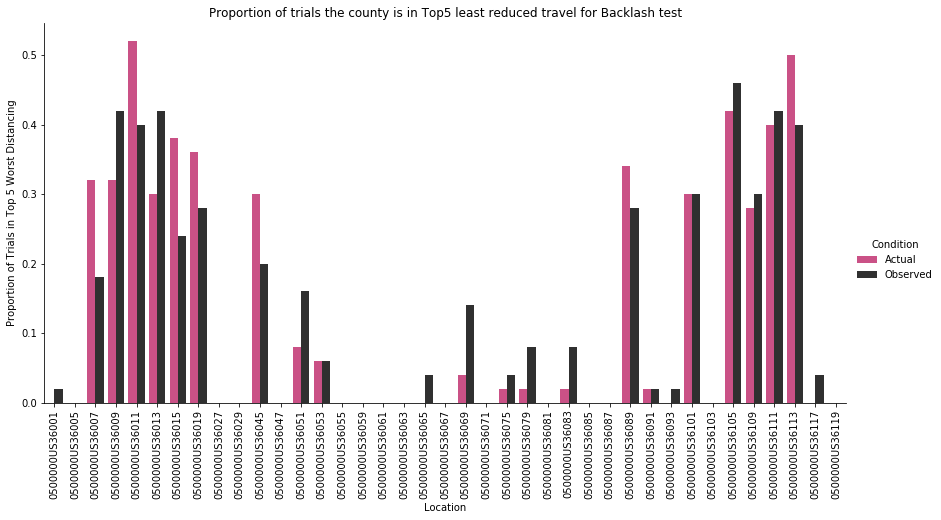

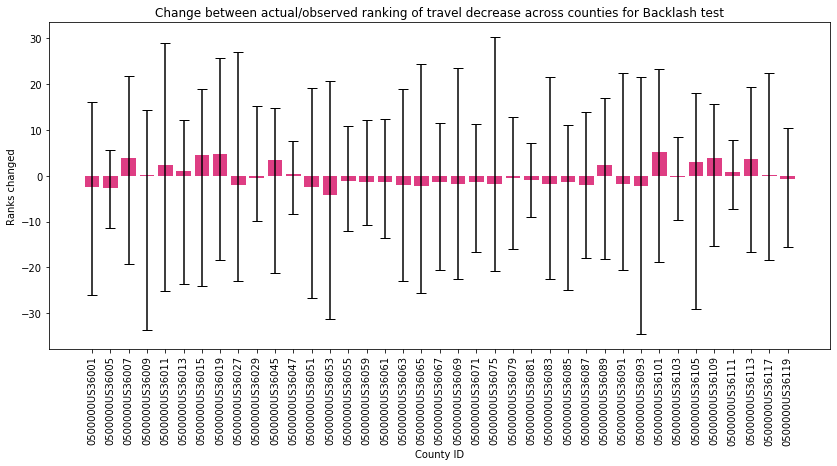

In [46]:
distributionplot(backlash_full_results, 'Backlash', "#de3d83", "#303030", "exp06_dist_stat_backlash")

bl_act, bl_obs, bl_change = rankingDFs(backlash_full_results, num_t)
topFivePlot(bl_act, bl_obs, 'Backlash', "#de3d83", "#303030", "exp06_top5_backlash", num_t)

rankchangesPlot(bl_change, 'Backlash', "#de3d83",  "exp06_rankchange_backlash")